## Plot cancer type prediction results

In this notebook, we'll visualize the results of our one-vs-rest cancer type prediction experiments. The files analyzed in this notebook are generated by the `run_cancer_type_prediction.py` script.

Notebook parameters:
* FILTER_CANCER_TYPES (list): cancer types to filter box plots to
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
results_dir = Path(cfg.results_dir, 'cancer_type').resolve()
# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'cancer_type')
print(results_df.shape)
results_df.head()

(3168, 9)


,auroc,aupr,cancer_type,training_data,signal,seed,data_type,fold,experiment
0,0.98013,0.69226,HNSC,methylation,signal,42,train,0,cancer_type
1,0.97116,0.56608,HNSC,methylation,signal,42,test,0,cancer_type
2,0.96767,0.49104,HNSC,methylation,signal,42,cv,0,cancer_type
3,0.97838,0.63986,HNSC,methylation,signal,42,train,1,cancer_type
4,0.98098,0.73787,HNSC,methylation,signal,42,test,1,cancer_type


Text(0.5, 1.0, 'Performance distribution for cancer type prediction, expression vs. methylation data')

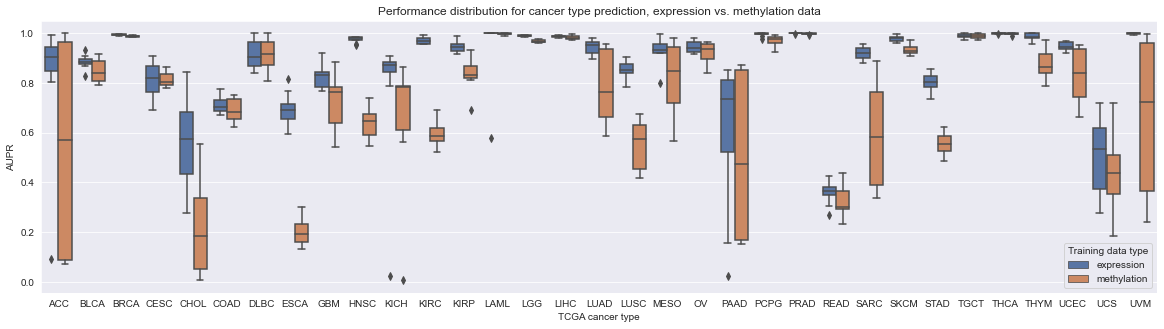

In [4]:
# set this variable to filter plot to certain cancer types
# if not included, plot all 33 of them
# FILTER_CANCER_TYPES = ['LUAD', 'LUSC', 'THCA']
FILTER_CANCER_TYPES = None
filtered_df = results_df[
    (results_df.signal == 'signal') &
    (results_df.data_type == 'test')
].copy()
if FILTER_CANCER_TYPES is not None:
    filtered_df = filtered_df[
        (filtered_df.cancer_type.isin(FILTER_CANCER_TYPES))
    ]
else:
    filtered_df.sort_values(by='cancer_type', inplace=True)

sns.set({'figure.figsize': (20, 5)})
sns.boxplot(data=filtered_df, x='cancer_type', y='aupr', hue='training_data',
            hue_order=np.sort(filtered_df.training_data.unique()))
plt.xlabel('TCGA cancer type')
plt.ylabel('AUPR')
plt.legend(title='Training data type')
plt.title('Performance distribution for cancer type prediction, expression vs. methylation data')

In [5]:
expression_df = (
    results_df[results_df.training_data == 'expression']
        .drop(columns=['training_data'])
)
expression_results_df = au.compare_results(expression_df,
                                           identifier='cancer_type',
                                           metric='aupr',
                                           correction=True,
                                           correction_method='fdr_bh',
                                           correction_alpha=SIG_ALPHA,
                                           verbose=True)
expression_results_df.sort_values(by='p_value').head(n=10)

,identifier,delta_mean,p_value,corr_pval,reject_null
32,UVM,0.987189,1.965954e-32,6.487650e-31,True
14,LGG,0.932533,8.908975e-32,1.469981e-30,True
15,LIHC,0.947121,5.414586e-31,5.956045e-30,True
22,PRAD,0.943061,4.596693e-30,3.792272e-29,True
28,THCA,0.943469,3.561681e-28,2.350710e-27,True
21,PCPG,0.974578,2.716160e-27,1.493888e-26,True
27,TGCT,0.970647,1.355018e-26,6.387942e-26,True
2,BRCA,0.879973,4.782931e-26,1.972959e-25,True
25,SKCM,0.947655,3.051930e-25,1.119041e-24,True
29,THYM,0.971184,3.676045e-25,1.132516e-24,True


In [6]:
methylation_df = (
    results_df[results_df.training_data == 'methylation']
        .drop(columns=['training_data'])
)
methylation_results_df = au.compare_results(methylation_df,
                                            identifier='cancer_type',
                                            metric='aupr',
                                            correction=True,
                                            correction_method='fdr_bh',
                                            correction_alpha=SIG_ALPHA,
                                            verbose=True)
methylation_results_df.sort_values(by='p_value').head(n=10)

,identifier,delta_mean,p_value,corr_pval,reject_null
13,LAML,0.984120,1.763488e-33,5.819512e-32,True
2,BRCA,0.879126,2.829479e-30,4.668641e-29,True
22,PRAD,0.941618,6.055723e-30,6.661296e-29,True
28,THCA,0.942295,1.798243e-28,1.483550e-27,True
15,LIHC,0.942383,1.760944e-27,1.162223e-26,True
14,LGG,0.907483,4.069059e-27,2.237983e-26,True
27,TGCT,0.970310,1.208365e-26,5.696579e-26,True
25,SKCM,0.905640,4.285559e-22,1.767793e-21,True
21,PCPG,0.949205,5.102517e-22,1.870923e-21,True
3,CESC,0.783270,2.721820e-19,8.982008e-19,True


396

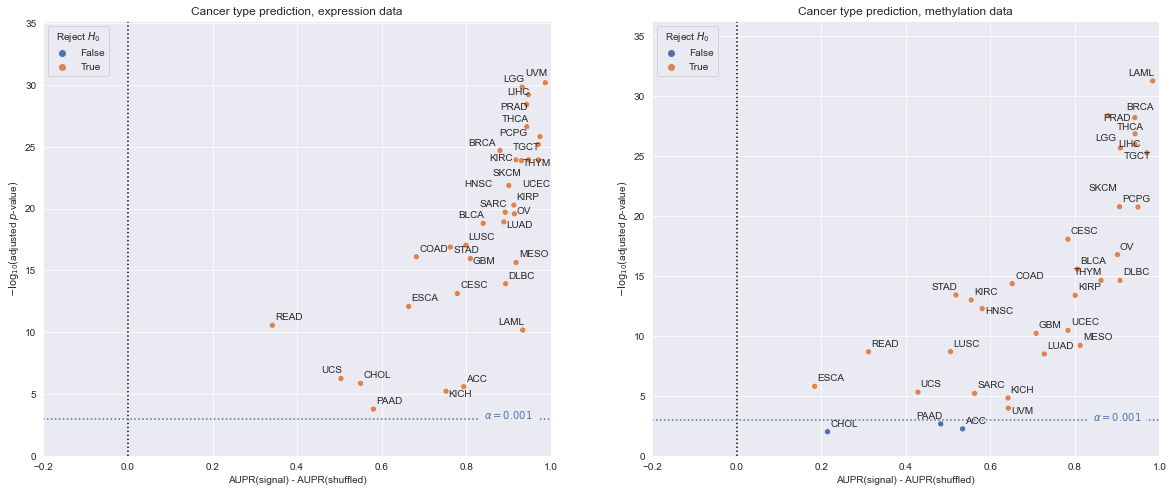

In [7]:
expression_results_df['nlog10_p'] = -np.log10(expression_results_df.corr_pval)
methylation_results_df['nlog10_p'] = -np.log10(methylation_results_df.corr_pval)

sns.set({'figure.figsize': (20, 8)})
fig, axarr = plt.subplots(1, 2)

# plot cancer type prediction from expression, in a volcano-like plot
sns.scatterplot(data=expression_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                hue_order=[False, True], ax=axarr[0])
# add vertical line at 0
axarr[0].axvline(x=0, linestyle=':', color='black')
# add horizontal line at statistical significance threshold
l = axarr[0].axhline(y=-np.log10(SIG_ALPHA), linestyle=':')
# label horizontal line with significance threshold
# (matplotlib makes this fairly difficult, sadly)
axarr[0].text(0.9, -np.log10(SIG_ALPHA)+0.3,
              r'$\alpha = {}$'.format(SIG_ALPHA),
              va='center', ha='center', color=l.get_color(),
              backgroundcolor=axarr[0].get_facecolor())
axarr[0].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[0].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[0].set_xlim((-0.2, 1.0))
axarr[0].set_ylim((0, expression_results_df.nlog10_p.max() + 5))
axarr[0].legend(title=r'Reject $H_0$', loc='upper left')
axarr[0].set_title(r'Cancer type prediction, expression data')

# plot cancer type prediction from methylation, same as above
sns.scatterplot(data=methylation_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                hue_order=[False, True], ax=axarr[1])
axarr[1].axvline(x=0, linestyle=':', color='black')
l = axarr[1].axhline(y=-np.log10(SIG_ALPHA), linestyle=':')
axarr[1].text(0.9, -np.log10(SIG_ALPHA)+0.3,
              r'$\alpha = {}$'.format(SIG_ALPHA),
              va='center', ha='center', color=l.get_color(),
              backgroundcolor=axarr[0].get_facecolor())
axarr[1].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[1].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[1].set_xlim((-0.2, 1.0))
axarr[1].set_ylim((0, methylation_results_df.nlog10_p.max() + 5))
axarr[1].legend(title=r'Reject $H_0$', loc='upper left')
axarr[1].set_title(r'Cancer type prediction, methylation data')

def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        text_labels.append(
            ax.text(point['x']+.005, point['y']+.2, str(point['gene']))
        )
    return text_labels

# label cancer types and adjust text to not overlap
# automatic alignment isn't perfect, can align by hand in inkscape if necessary
text_labels_expression = label_points(expression_results_df['delta_mean'],
                                      expression_results_df['nlog10_p'],
                                      expression_results_df.identifier,
                                      expression_results_df.reject_null,
                                      axarr[0])
adjust_text(text_labels_expression, ax=axarr[0])

text_labels_methylation = label_points(methylation_results_df['delta_mean'],
                                       methylation_results_df['nlog10_p'],
                                       methylation_results_df.identifier,
                                       methylation_results_df.reject_null,
                                       axarr[1])
adjust_text(text_labels_methylation, ax=axarr[1])

In [8]:
compare_results_df = au.compare_results(methylation_df,
                                        pancancer_df=expression_df,
                                        identifier='cancer_type',
                                        metric='aupr',
                                        correction=True,
                                        correction_method='fdr_bh',
                                        correction_alpha=SIG_ALPHA,
                                        verbose=True)
compare_results_df.sort_values(by='p_value').head()

,identifier,delta_mean,p_value,corr_pval,reject_null
16,KIRC,0.374143,1.463741e-11,4.830344e-10,True
20,HNSC,0.338929,5.335970e-10,8.804351e-09,True
0,ESCA,0.486467,1.401703e-09,1.541873e-08,True
12,STAD,0.244744,1.609013e-08,1.327436e-07,True
9,LGG,0.023232,7.348924e-08,4.850290e-07,True


5

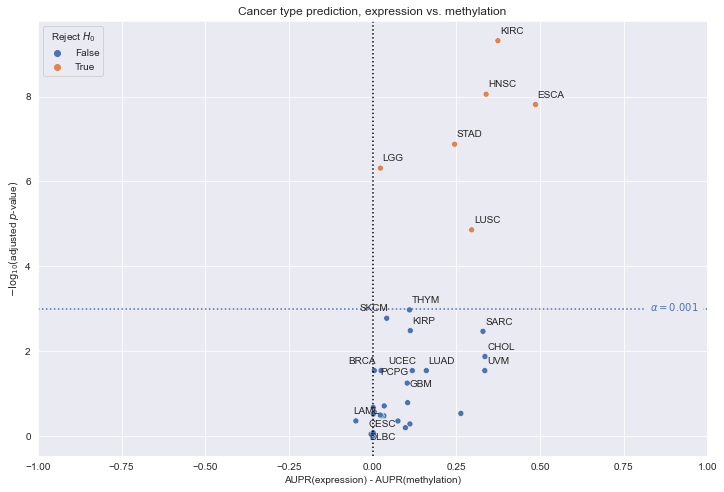

In [9]:
compare_results_df['nlog10_p'] = -np.log10(compare_results_df.corr_pval)

sns.set({'figure.figsize': (12, 8)})
sns.scatterplot(data=compare_results_df, x='delta_mean', y='nlog10_p', hue='reject_null')
plt.axvline(x=0, linestyle=':', color='black')
l = plt.axhline(y=-np.log10(SIG_ALPHA), linestyle=':')
plt.text(0.9, -np.log10(SIG_ALPHA)+0.05,
         r'$\alpha = {}$'.format(SIG_ALPHA),
         va='center', ha='center', color=l.get_color(),
         backgroundcolor=plt.gca().get_facecolor())
plt.xlabel('AUPR(expression) - AUPR(methylation)')
plt.ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
plt.xlim((-1.0, 1.0))
plt.legend(title=r'Reject $H_0$', loc='upper left')
plt.title(r'Cancer type prediction, expression vs. methylation')

def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(0.1):
            text_labels.append(
                ax.text(point['x']+.005, point['y']+.1, str(point['gene']))
            )
        elif point['x'] < 0.0:
            # align these left, otherwise can't read
            text_labels.append(
                ax.text(point['x']-.01, point['y']+.1, str(point['gene']),
                        ha='right', va='bottom')
            )
    return text_labels

text_labels = label_points(compare_results_df['delta_mean'],
                           compare_results_df['nlog10_p'],
                           compare_results_df.identifier,
                           compare_results_df.reject_null,
                           plt.gca())
adjust_text(text_labels, ax=plt.gca())

## Confusion matrix

In [10]:
import os

import mpmp.utilities.data_utilities as du

preds_dir = os.path.join(cfg.repo_root, 'results_preds', 'cancer_type')
sample_info_df = du.load_sample_info()

preds_expression_df = au.load_preds_to_matrix(preds_dir, sample_info_df,
                                              training_data='expression')
print(preds_expression_df.shape)
preds_expression_df.iloc[:5, :5]

(33, 33)


cancer_type,ACC,BLCA,BRCA,CESC,CHOL
ACC,0.936842,0.129160,0.139193,0.133552,0.143551
BLCA,0.079862,0.847383,0.095647,0.404291,0.091285
BRCA,0.030193,0.034806,0.907143,0.037347,0.020433
CESC,0.087911,0.240968,0.110421,0.867470,0.112648
CHOL,0.048104,0.062890,0.044219,0.060519,0.736422


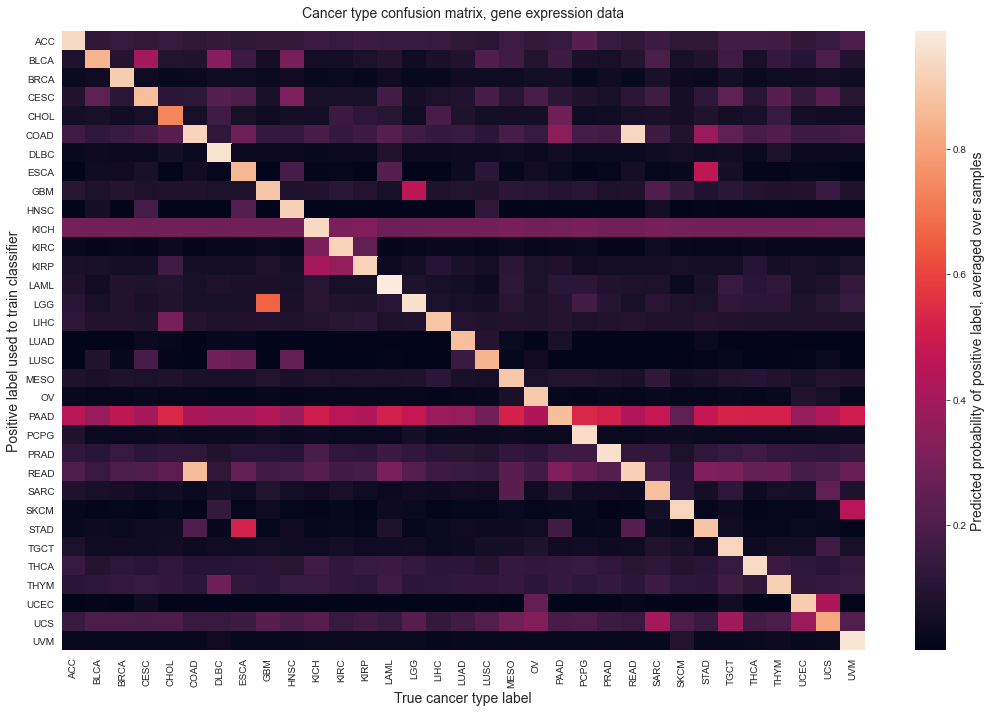

In [11]:
sns.set({'figure.figsize': (15, 10)})
ax = sns.heatmap(preds_expression_df, cbar_kws={'label': 'Predicted probability of positive label, averaged over samples'})
# this is needed to increase colorbar label font size
# https://stackoverflow.com/a/48587137
ax.figure.axes[-1].yaxis.label.set_size(14)
plt.xlabel('True cancer type label', size=14)
plt.ylabel('Positive label used to train classifier', size=14)
plt.title('Cancer type confusion matrix, gene expression data', size=14, pad=14)
plt.tight_layout()

In [12]:
preds_methylation_df = au.load_preds_to_matrix(preds_dir, sample_info_df,
                                               training_data='methylation')
print(preds_methylation_df.shape)
preds_methylation_df.iloc[:5, :5]

(33, 33)


cancer_type,ACC,BLCA,BRCA,CESC,CHOL
ACC,0.838511,0.409891,0.297222,0.249270,0.226047
BLCA,0.130331,0.724238,0.225753,0.371259,0.127574
BRCA,0.214023,0.272306,0.765063,0.392734,0.202278
CESC,0.102136,0.364732,0.240462,0.795108,0.161401
CHOL,0.212035,0.234763,0.192737,0.198581,0.704338


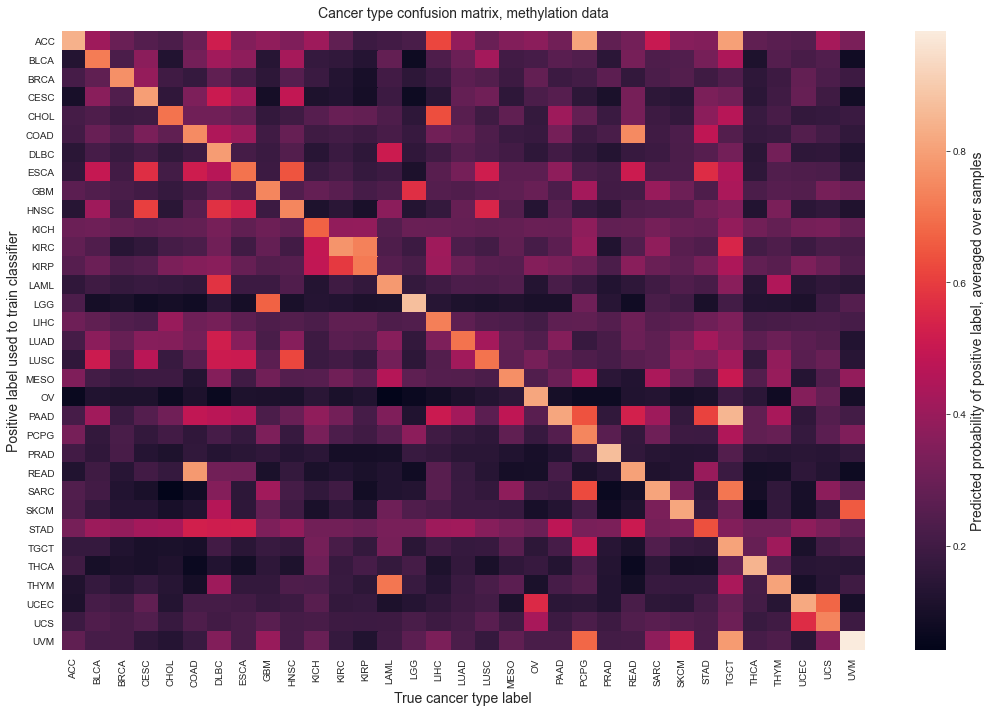

In [13]:
sns.set({'figure.figsize': (15, 10)})
ax = sns.heatmap(preds_methylation_df, cbar_kws={'label': 'Predicted probability of positive label, averaged over samples'})
# this is needed to increase colorbar label font size
# https://stackoverflow.com/a/48587137
ax.figure.axes[-1].yaxis.label.set_size(14)
plt.xlabel('True cancer type label', size=14)
plt.ylabel('Positive label used to train classifier', size=14)
plt.title('Cancer type confusion matrix, methylation data', size=14, pad=14)
plt.tight_layout()

How to read the confusion matrices:

* Remember, we're doing one-vs-rest classification of the cancer types. The cancer type on the y-axis is what the model is trained to predict (i.e. the positive label in the training set), and the cancer type on the x-axis is what we're evaluating on (i.e. the true label in the test set).

* A high off-diagonal value in the heatmap indicates that a model trained to distinguish the y-axis cancer type from all the others often "confuses" it for the x-axis cancer type (i.e. they have similar gene expression profiles). Diagonal values indicate the accuracy of the model on the target cancer type (these values should be relatively high).

In the resulting heatmaps, we can observe a few things:

* The models are accurate overall (high on-diagonal values and mostly low off-diagonal values), and the "inaccuracies" (high off-diagonal values) we see aren't surprising based on our knowledge of relationships between cancer types.

* Cancer type predictions using methylation data are noisier and not quite as accurate compared to gene expression data.

Text(0.5, 0, 'Cancer type')

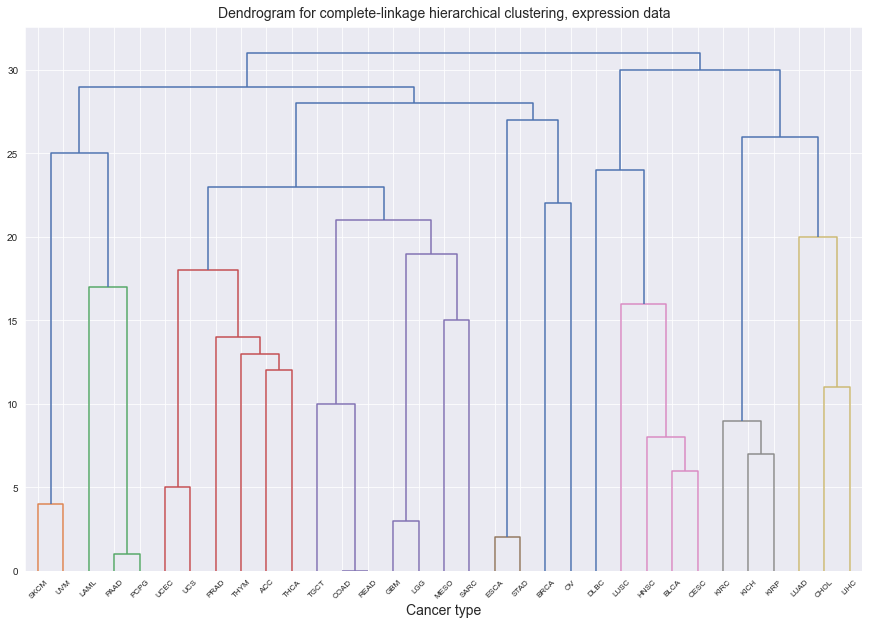

In [14]:
# cluster and plot dendrogram
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
def plot_dendrogram(model, **kwargs):
    
    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(model.children_.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, model.children_.shape[0]+2)

    linkage_matrix = np.column_stack([model.children_,
                                      distance,
                                      no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
# fit agglomerative clustering model to confusion (similarity) matrix
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                affinity='precomputed',
                                linkage='complete')
# takes a distance matrix (1 - similarity)
model = model.fit(1 - preds_expression_df.values)

plot_dendrogram(model, labels=preds_expression_df.index.values)
plt.title('Dendrogram for complete-linkage hierarchical clustering, expression data',
          size=14, pad=10)
plt.xlabel('Cancer type', size=14)

Text(0.5, 0, 'Cancer type')

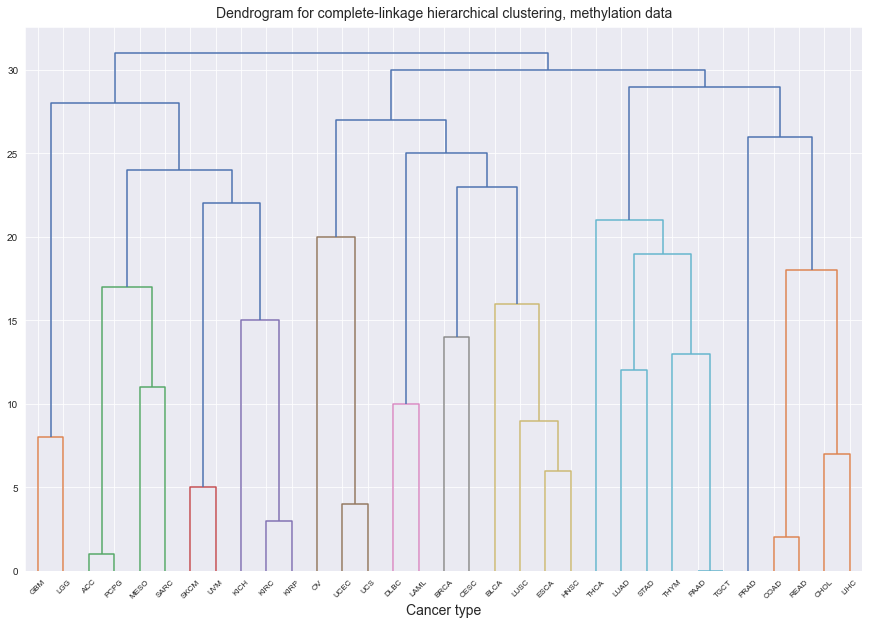

In [15]:
# fit agglomerative clustering model to confusion (similarity) matrix
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                affinity='precomputed',
                                linkage='complete')
# takes a distance matrix (1 - similarity)
model = model.fit(1 - preds_methylation_df.values)

plot_dendrogram(model, labels=preds_methylation_df.index.values)
plt.title('Dendrogram for complete-linkage hierarchical clustering, methylation data',
          size=14, pad=10)
plt.xlabel('Cancer type', size=14)

## Confusion matrix with subsampled cancer types

In [16]:
preds_dir = os.path.join(cfg.repo_root, 'results_preds_subsampled', 'cancer_type')

preds_expression_ss_df = au.load_preds_to_matrix(preds_dir, sample_info_df,
                                                 training_data='expression')
# take average over multiple seeds/subsampling replicates
# TODO: could do this in the load function?
preds_expression_ss_df = preds_expression_ss_df.groupby(preds_expression_ss_df.index).mean()
print(preds_expression_ss_df.shape)
preds_expression_ss_df.iloc[:5, :5]

(33, 33)


cancer_type,ACC,BLCA,BRCA,CESC,CHOL
ACC,0.925469,0.049457,0.069830,0.049323,0.043428
BLCA,0.045543,0.720420,0.074587,0.258099,0.062913
BRCA,0.057928,0.084917,0.788864,0.074980,0.056895
CESC,0.020042,0.145452,0.046676,0.751762,0.035665
CHOL,0.095387,0.085579,0.108095,0.101590,0.794310


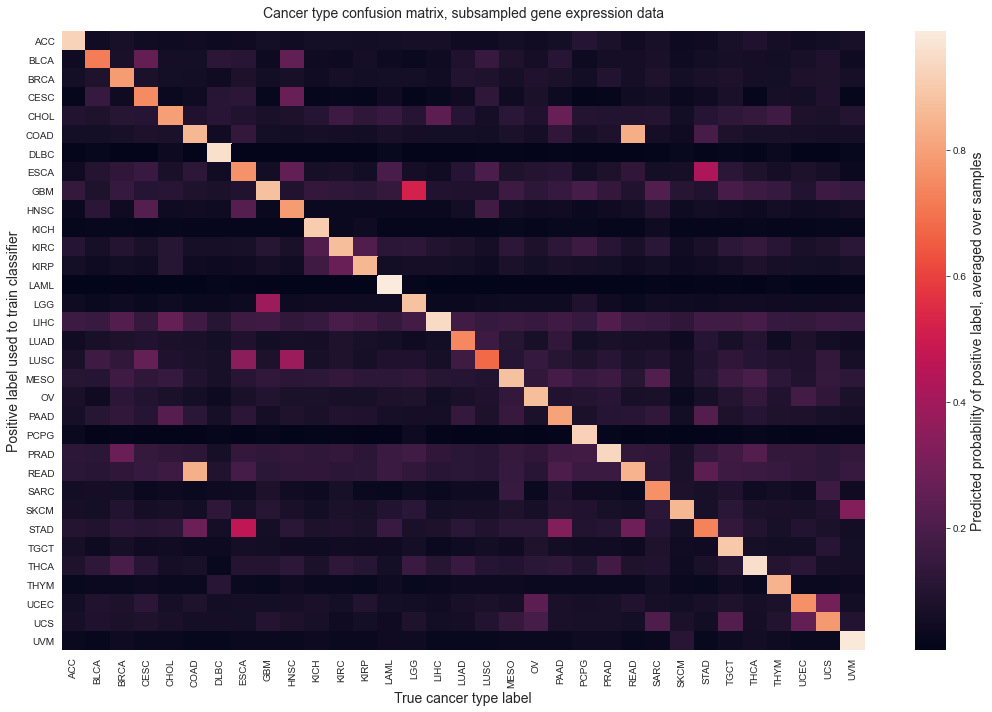

In [17]:
sns.set({'figure.figsize': (15, 10)})
ax = sns.heatmap(preds_expression_ss_df, cbar_kws={'label': 'Predicted probability of positive label, averaged over samples'})
# this is needed to increase colorbar label font size
# https://stackoverflow.com/a/48587137
ax.figure.axes[-1].yaxis.label.set_size(14)
plt.xlabel('True cancer type label', size=14)
plt.ylabel('Positive label used to train classifier', size=14)
plt.title('Cancer type confusion matrix, subsampled gene expression data', size=14, pad=14)
plt.tight_layout()

Text(0.5, 0, 'Cancer type')

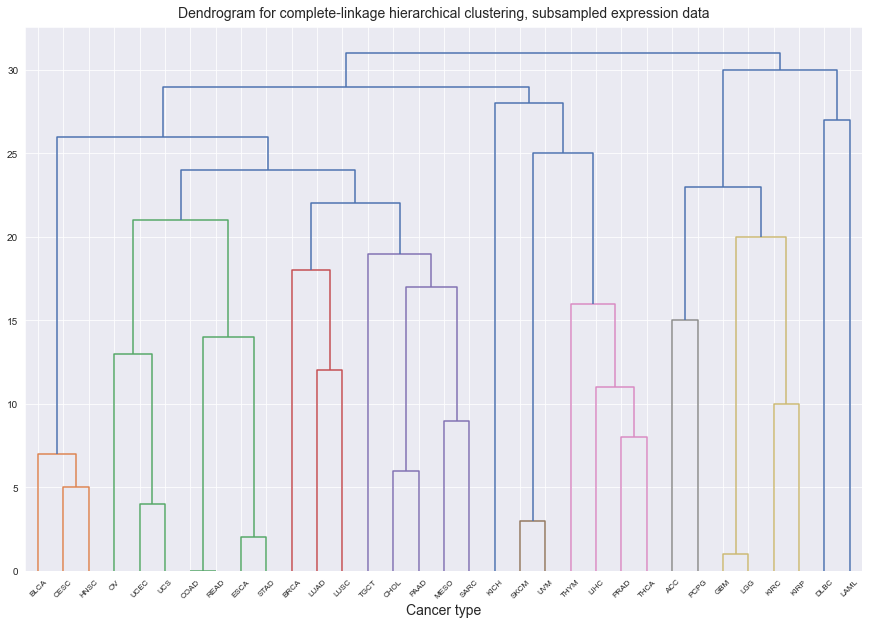

In [18]:
# fit agglomerative clustering model to confusion (similarity) matrix
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                affinity='precomputed',
                                linkage='complete')
# takes a distance matrix (1 - similarity)
model = model.fit(1 - preds_expression_ss_df.values)

plot_dendrogram(model, labels=preds_expression_ss_df.index.values)
plt.title('Dendrogram for complete-linkage hierarchical clustering, subsampled expression data',
          size=14, pad=10)
plt.xlabel('Cancer type', size=14)

In [19]:
# save subsampled confusion matrix to file
preds_expression_ss_df.to_csv(
    os.path.join(cfg.data_dir, 'expression_confusion_matrix.tsv'),
    sep='\t', float_format='%.5g'
)